# Generalized dynamic programming for multiple sequence alignment

It's possible to generalize Smith-Waterman and Needleman-Wunsch, the dynamic programming algorithms that we explored for pairwise sequence aligment, to identify the optimal alignment of more than two sequences. Remember that our scoring scheme for pairwise alignment with Smith-Waterman looked like the following:


$F(0, 0) = 0$

$F(i, 0) = F(i-1, 0) - d$

$F(0, j) = F(0, j-1) - d$

$
F(i, j) = max \left(\begin{align}
F(i-1, j-1) + s(c_i, c_j)\\
F(i-1, j) - d\\
F(i, j-1) - d)
\end{align}\right)$

To generalize this to three sequences, we could create 3x3 score, dynamic programming, and traceback matrices. Our scoring scheme would then look like the following:


$F(0, 0, 0) = 0$

$F(i, 0, 0) = F(i-1, 0, 0) - d$

$F(0, j, 0) = F(0, j-1, 0) - d$

$F(0, 0, k) = F(0, 0, k-1) - d$

$
F(i, j, k) = max \left(\begin{align}
F(i-1, j-1, k-1) + s(c_i, c_j) + s(c_i, c_k) + s(c_j, c_k)\\
F(i, j-1, k-1) + s(c_j, c_k) - d\\
F(i-1, j, k-1) + s(c_i, c_k) - d\\
F(i-1, j-1, k) + s(c_i, c_j) - d\\
F(i, j, k-1) - 2d\\
F(i, j-1, k) - 2d\\
F(i-1, j, k) - 2d\\
\end{align}\right)$

However the complexity of this algorithm is much worse than for pairwise alignment. For pairwise alignment, remember that if aligning two sequences of lengths $m$ and $n$, the runtime of the algorithm will be proportional to $m \times n$. If $n$ is longer than or as long as $m$, we simplify the statement to say that the runtime of the algorithm will be be proportional to $n^2$. This curve has a pretty scary trajectory: runtime for pairwise alignment with dynamic programming is said to scale quadratically.

In [2]:
# first we need to do some configuration of the notebook, don't worry about this for now
%matplotlib inline
from __future__ import division, print_function
from functools import partial
from IPython.core import page
page.page = print

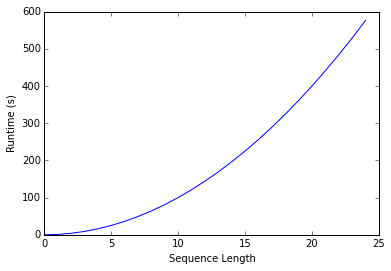

In [3]:
import matplotlib.pyplot as plt

seq_lengths = range(25)
s2_times = [t ** 2 for t in range(25)]

plt.plot(range(25), s2_times)
plt.xlabel('Sequence Length')
plt.ylabel('Runtime (s)')

**The exponent in the $n^2$ term comes from the fact that, in pairwise alignment, if we assume our sequences are both of length $n$, there are $n \times n$ cells to fill in in the dynamic programming matrix. If we were to generalize either Smith-Waterman or Needleman-Wunsch to three sequences, we would need to create a 3 dimensional array to score and traceback the alignment.** For sequences of length $n$, we would therefore have $n \times n \times n$ cells to fill in, and our runtime versus sequence length curve would look like the following.

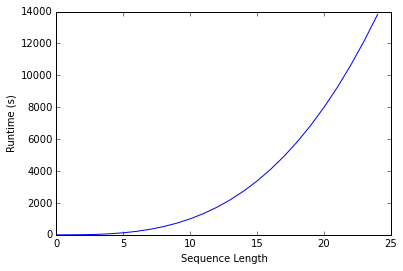

In [4]:
s3_times = [t ** 3 for t in range(25)]

plt.plot(range(25), s3_times)
plt.xlabel('Sequence Length')
plt.ylabel('Runtime (s)')

That curve looks steeper than the curve for pairwise alignment, and the values on the y-axis are bigger, but it's not really clear how much of a problem this is until we plot runtime for three sequences in the context of the run times for pairwise alignment.

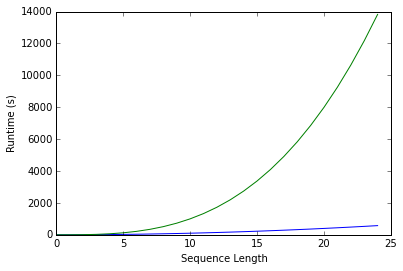

In [5]:
plt.plot(range(25), s2_times)
plt.plot(range(25), s3_times)
plt.xlabel('Sequence Length')
plt.ylabel('Runtime (s)')

And for four sequences:

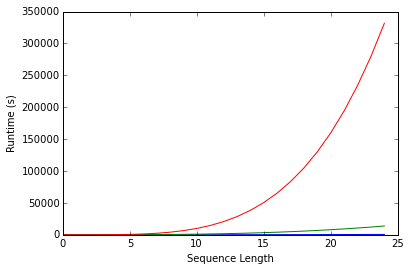

In [6]:
s4_times = [t ** 4 for t in range(25)]

plt.plot(range(25), s2_times)
plt.plot(range(25), s3_times)
plt.plot(range(25), s4_times)
plt.xlabel('Sequence Length')
plt.ylabel('Runtime (s)')

We clearly have a problem here, and that is that **the runtime for multiple sequence alignment using full dynamic programming algoriths grows exponentially with the number of sequences to be aligned**. If $n$ is our sequence length, and $s$ is the number of sequences, that means that runtime is proportional to $n^s$. In pairwise alignment, $s$ is always equal to 2, so the problem is more manangeable. However, **for the general case of $s$ sequences, we really can't even consider Smith-Waterman or Needleman-Wunsch for more than just a few sequences.** The pattern in the plots above should illustrate why. 

As we explored with database searching, we need to figure out how to align fewer sequences. This is where *progressive alignment* comes in.

# Progressive alignment

<div style="float: right; margin-left: 30px;"><img title="Image by @gregcaporaso." style="float: right; margin-left: 30px;" src="files/images/confusion.png" align=right width=330/></div>

**In progressive alignment, the problem of exponential growth of runtime and space is managed by selectively aligning pairs of sequences, and aligning alignments of sequences.** What we typically do is identify a pair of closely sequences, and align those. Then, we identify the next closely related sequence to that initial pair, and align that sequence to the alignment. This concept of aligning a sequence to an alignment is new, and we'll come back to it in just a few minutes. The other concept of identifying the most closely related sequences, and then the next most closely related sequence, and so on should sound familar. It effectively means that we're traversing a tree. And herein lies our problem: **we need a tree to efficently align multiple sequences, but we need an alignment to build a good tree**. 

You probably have two burning questions in your mind right now:

1. How do we build a tree to guide the alignment process, if we need an alignment to build a good tree?
2. How do we align a sequence to an alignment, or an alignment to an alignment?

We'll explore both of those through-out the rest of this notebook. First, let's cover the process of progressive multiple sequence alignment, just assuming for a moment that we know how to do both of those things.

The process of progressive multiple sequence alignment could look like the following. First, we start with some sequences and a tree representing the relationship between those sequences. We'll call this our **guide tree**, because it's going to guide us through the process of multiple sequence alignment. In progressive multiple sequence alignment, we build a multiple sequence alignment for each internal node of the tree, where the alignment at a given internal node contains all of the sequences in the clade defined by that node.

<img src="files/images/msa-tree-input.png">

Starting from the root node, descend the bottom branch of the tree until you get to the an internal node. If an alignment hasn't been constructed for that node yet, continue descending the tree until to get to a pair of nodes. In this case, we follow the two branches to the tips. We then align the sequences at that pair of tips (usually with Needleman-Wunsch, for multiple sequence alignment), and assign that alignment to the node connecting those tips.

<img src="files/images/msa-tree-a1.png">

Next, we want to find what to align the resulting alignment to, so start from the root node and descend the top branch of the tree. When you get to the next node, determine if an alignment has already been created for that node. If not, our job is to build that alignment so we have something to align against. In this case, that means that we need to align `s1`, `s2`, and `s3`. We can achieve this by aligning `s1` and `s3` first, to get the alignment at the internal node connecting them.

<img src="files/images/msa-tree-a2.png">

We can next align the alignment of `s1` and `s3` with `s2`, to get the alignment at the internal node connecting those clades.

<img src="files/images/msa-tree-a3.png">

And finally, we can compute the alignment at the root node of the tree, by aligning the alignment of `s1`, `s2`, and `s3` with the alignment of `s4` and `s5`.

<img src="files/images/msa-tree-final.png">

**The alignment at the root node is our multiple sequence alignment.**


## Building the guide tree

Let's address the first of our outstanding questions. **I mentioned above that *we need an alignment to build a good tree*. The key word here is *good*. We can build a very rough tree - one that we would never want to present as representing the actual relationships between the sequences in question - without first aligning the sequences.** Remember that building a UPGMA tree requires only a distance matrix, so if we can find a non-alignment-dependent way to compute distances between the sequences, we can build a rough UPGMA tree from them.

Let's compute distances between the sequences based on their *word* composition. We'll define a *word* here as `k` adjacent characters in the sequence. We can then define a function that will return all of the words in a sequence as follows. These words can be defined as being overlapping, or non-overlapping. We'll go with overlapping for this example, as the more words we have, the better our guide tree should be.

In [7]:
from skbio import BiologicalSequence
%psource BiologicalSequence.k_words

    def k_words(self, k, overlapping=True):
        """Get the list of words of length k

        Parameters
        ----------
        k : int
            The word length.
        overlapping : bool, optional
            Defines whether the k-words should be overlapping or not
            overlapping.

        Returns
        -------
        iterator of BiologicalSequences
            Iterator of words of length `k` contained in the
            BiologicalSequence.

        Raises
        ------
        ValueError
            If k < 1.

        Examples
        --------
        >>> from skbio.sequence import BiologicalSequence
        >>> s = BiologicalSequence('ACACGACGTT')
        >>> [str(kw) for kw in s.k_words(4, overlapping=False)]
        ['ACAC', 'GACG']
        >>> [str(kw) for kw in s.k_words(3, overlapping=True)]
        ['ACA', 'CAC', 'ACG', 'CGA', 'GAC', 'ACG', 'CGT', 'GTT']

        """
        if k < 1:
            raise ValueError("k must be greater than 0.")

        s

In [8]:
for e in BiologicalSequence("ACCGGTGACCAGTTGACCAGTA").k_words(3):
    print(e)

ACC
CCG
CGG
GGT
GTG
TGA
GAC
ACC
CCA
CAG
AGT
GTT
TTG
TGA
GAC
ACC
CCA
CAG
AGT
GTA


In [9]:
for e in BiologicalSequence("ACCGGTGACCAGTTGACCAGTA").k_words(7):
    print(e)

ACCGGTG
CCGGTGA
CGGTGAC
GGTGACC
GTGACCA
TGACCAG
GACCAGT
ACCAGTT
CCAGTTG
CAGTTGA
AGTTGAC
GTTGACC
TTGACCA
TGACCAG
GACCAGT
ACCAGTA


In [10]:
for e in BiologicalSequence("ACCGGTGACCAGTTGACCAGTA").k_words(3, overlapping=False):
    print(e)

ACC
GGT
GAC
CAG
TTG
ACC
AGT


If we then have two sequences, we can compute the word counts for each and define a distance between the sequences as the fraction of words that are unique to either sequence. 

In [11]:
from iab.algorithms import kmer_distance
%psource kmer_distance

def kmer_distance(sequence1, sequence2, k=3, overlapping=True):
    """Compute the kmer distance between a pair of sequences

    Parameters
    ----------
    sequence1 : BiologicalSequence
    sequence2 : BiologicalSequence
    k : int, optional
        The word length.
    overlapping : bool, optional
        Defines whether the k-words should be overlapping or not
        overlapping.

    Returns
    -------
    float
        Fraction of the set of k-mers from both sequence1 and
        sequence2 that are unique to either sequence1 or
        sequence2.

    Raises
    ------
    ValueError
        If k < 1.

    Notes
    -----
    k-mer counts are not incorporated in this distance metric.

    """
    sequence1_kmers = set(sequence1.k_words(k, overlapping))
    sequence2_kmers = set(sequence2.k_words(k, overlapping))
    all_kmers = sequence1_kmers | sequence2_kmers
    shared_kmers = sequence1_kmers & sequence2_kmers
    number_unique = len(all_kmers) - len(shared_kmers)
    fr

We can then use this as a distance function...

In [12]:
s1 = BiologicalSequence("ACCGGTGACCAGTTGACCAGT")
s2 = BiologicalSequence("ATCGGTACCGGTAGAAGT")
s3 = BiologicalSequence("GGTACCAAATAGAA")

print(s1.distance(s2, kmer_distance))
print(s1.distance(s3, kmer_distance))

0.75
0.857142857143


If we wanted to override the default to create (for example) a 5-mer distance function, we could use ``functools.partial``.

In [13]:
fivemer_distance = partial(kmer_distance, k=5)

s1 = BiologicalSequence("ACCGGTGACCAGTTGACCAGT")
s2 = BiologicalSequence("ATCGGTACCGGTAGAAGT")
s3 = BiologicalSequence("GGTACCAAATAGAA")

print(s1.distance(s2, fivemer_distance))
print(s1.distance(s3, fivemer_distance))

0.916666666667
1.0


We can now apply one of these functions to build a distance matrix for a set of sequences that we want to align.

In [14]:
from skbio import SequenceCollection
query_sequences = SequenceCollection(
                   [BiologicalSequence("ACCGGTGACCAGTTGACCAGT", "s1"),
                    BiologicalSequence("ATCGGTACCGGTAGAAGT", "s2"),
                    BiologicalSequence("GGTACCAAATAGAA", "s3"),
                    BiologicalSequence("GGCACCAAACAGAA", "s4"),
                    BiologicalSequence("GGCCCACTGAT", "s5")])

In [15]:
guide_dm = query_sequences.distances(kmer_distance)
print(guide_dm)

5x5 distance matrix
IDs:
's1', 's2', 's3', 's4', 's5'
Data:
[[ 0.          0.75        0.85714286  0.85714286  0.89473684]
 [ 0.75        0.          0.61111111  0.86363636  1.        ]
 [ 0.85714286  0.61111111  0.          0.66666667  0.95      ]
 [ 0.85714286  0.86363636  0.66666667  0.          0.83333333]
 [ 0.89473684  1.          0.95        0.83333333  0.        ]]


scikit-bio also has some basic visualization functinality for these objects. For example, we can easily visualize this object as a heatmap.

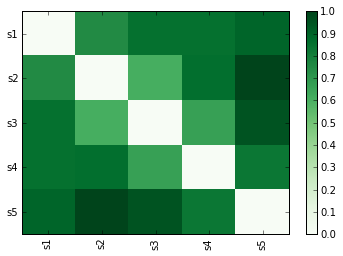

In [16]:
fig = guide_dm.plot(cmap='Greens')

We can next use some functionality from SciPy to cluster the sequences with UPGMA, and print out a **dendrogram**.

ACCGGTGACCAGTTGACCAGT
ATCGGTACCGGTAGAAGT
GGTACCAAATAGAA
GGCACCAAACAGAA
GGCCCACTGAT


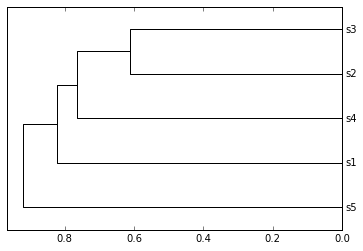

In [17]:
from scipy.cluster.hierarchy import average, dendrogram, to_tree

for q in query_sequences:
    print(q)

guide_lm = average(guide_dm.condensed_form())    
guide_d = dendrogram(guide_lm, labels=guide_dm.ids, orientation='right', 
                     link_color_func=lambda x: 'black')
guide_tree = to_tree(guide_lm)

In [18]:
from iab.algorithms import guide_tree_from_sequences
%psource guide_tree_from_sequences

def guide_tree_from_sequences(sequences,
                              distance_fn=kmer_distance,
                              display_tree = False):
    """ Build a UPGMA tree by applying distance_fn to sequences

    Parameters
    ----------
    sequences : skbio.SequenceCollection
      The sequences to be represented in the resulting guide tree.
    sequence_distance_fn : function
      Function that returns and skbio.DistanceMatrix given an
      skbio.SequenceCollection.
    display_tree : bool, optional
      Print the tree before returning.

    Returns
    -------
    skbio.TreeNode

    """
    guide_dm = sequences.distances(distance_fn)
    guide_lm = average(guide_dm.condensed_form())
    guide_tree = to_tree(guide_lm)
    if display_tree:
        guide_d = dendrogram(guide_lm, labels=guide_dm.ids, orientation='right',
               link_color_func=lambda x: 'black')
    return guide_tree



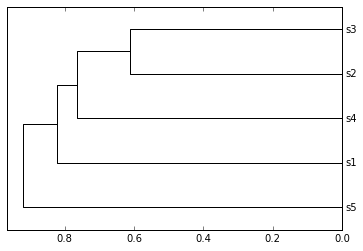

In [19]:
t = guide_tree_from_sequences(query_sequences, display_tree=True)

We now have a guide tree, so we can move on to the next step of progressive alignment.

## Generalization of Needleman-Wunsch (with affine gap scoring) for progressive multiple sequence alignment

Next, we'll address our second burning question: aligning alignments. As illustrated above, there are basically three different types of pairwise alignment we need to support for progressive multiple sequenence alignment with Needleman-Wunsch. These are:

1. Alignment of a pair of sequences.
2. Alignment of a sequence and an alignment.
3. Alignment of a pair of alignments.

Standard Needleman-Wunsch supports the first, and it is very easy to generalize it to support the latter two. The only change that is necessary is in how the alignment of two non-gap characters is scored. Recall that we previously scored an alignment of two characters by looking up the score of subsitution from one to the other in a substitution matrix. To adapt this for aligning a sequence to an alignment, or for aligning an alignment to an alignment, we compute this subsitution as the average score of aligning the pairs of characters. 

For example, if we want to align the alignment column from $aln1$:

``
A
C
``

to the alignment column from $aln2$:

``
T
G
``

we could compute the subsitution score using the matrix $m$ as:

$$
s = \frac{m[A][T] + m[A][G] + m[C][T] + m[C][G]}{aln1_{length} \times aln2_{length}}
$$

The following code adapts our implementation of Needleman-Wunsh to support aligning a sequence to an alignment, or aligning an alignment to an alignment.

In [20]:
from iab.algorithms import format_dynamic_programming_matrix, format_traceback_matrix
from skbio.alignment._pairwise import _compute_score_and_traceback_matrices 

%psource _compute_score_and_traceback_matrices

def _compute_score_and_traceback_matrices(
        aln1, aln2, gap_open_penalty, gap_extend_penalty, substitution_matrix,
        new_alignment_score=-np.inf, init_matrices_f=_init_matrices_nw,
        penalize_terminal_gaps=True, gap_substitution_score=0):
    """Return dynamic programming (score) and traceback matrices.

    A note on the ``penalize_terminal_gaps`` parameter. When this value is
    ``False``, this function is no longer true Smith-Waterman/Needleman-Wunsch
    scoring, but when ``True`` it can result in biologically irrelevant
    artifacts in Needleman-Wunsch (global) alignments. Specifically, if one
    sequence is longer than the other (e.g., if aligning a primer sequence to
    an amplification product, or searching for a gene in a genome) the shorter
    sequence will have a long gap inserted. The parameter is ``True`` by
    default (so that this function computes the score and traceback matrices as
    described by the original authors) but the global alignment

In [21]:
from skbio.alignment._pairwise import _traceback
%psource _traceback

def _traceback(traceback_matrix, score_matrix, aln1, aln2, start_row,
               start_col, gap_character='-'):
    # cache some values for simpler
    aend = _traceback_encoding['alignment-end']
    match = _traceback_encoding['match']
    vgap = _traceback_encoding['vertical-gap']
    hgap = _traceback_encoding['horizontal-gap']

    # initialize the result alignments
    aln1_sequence_count = aln1.sequence_count()
    aligned_seqs1 = [[] for e in range(aln1_sequence_count)]

    aln2_sequence_count = aln2.sequence_count()
    aligned_seqs2 = [[] for e in range(aln2_sequence_count)]

    current_row = start_row
    current_col = start_col

    best_score = score_matrix[current_row, current_col]
    current_value = None

    while current_value != aend:
        current_value = traceback_matrix[current_row, current_col]

        if current_value == match:
            for aligned_seq, input_seq in zip(aligned_seqs1, aln1):
                aligned_seq.append(str(input_seq[current_col

In [22]:
from skbio.alignment import global_pairwise_align_nucleotide
%psource global_pairwise_align_nucleotide 

def global_pairwise_align_nucleotide(seq1, seq2, gap_open_penalty=5,
                                     gap_extend_penalty=2,
                                     match_score=1, mismatch_score=-2,
                                     substitution_matrix=None,
                                     penalize_terminal_gaps=False):
    """Globally align pair of nuc. seqs or alignments with Needleman-Wunsch

    Parameters
    ----------
    seq1 : str, BiologicalSequence, or Alignment
        The first unaligned sequence(s).
    seq2 : str, BiologicalSequence, or Alignment
        The second unaligned sequence(s).
    gap_open_penalty : int or float, optional
        Penalty for opening a gap (this is substracted from previous best
        alignment score, so is typically positive).
    gap_extend_penalty : int or float, optional
        Penalty for extending a gap (this is substracted from previous best
        alignment score, so is typically positive).
    match_score : int or float, op

For the sake of the examples below, I'm going to override one of the ``global_pairwise_align_nucleotide`` defaults to penalize terminal gaps. This effectively tells the algorithm that we know we have a collection of sequences that are homologous from beginning to end.

In [23]:
global_pairwise_align_nucleotide = partial(global_pairwise_align_nucleotide, penalize_terminal_gaps=True)

For example, we can still use this code to align pairs of sequences (but note that we now need to pass those sequences in as a pair of one-item lists):

In [24]:
print(query_sequences[0])
print(query_sequences[1])

aln1 = global_pairwise_align_nucleotide(query_sequences[0], query_sequences[1])
print(aln1)

ACCGGTGACCAGTTGACCAGT
ATCGGTACCGGTAGAAGT
>s1
ACCGGTGACCAGTTGACCAGT
>s2
ATCGGT-ACCGGTAGA--AGT



/Users/caporaso/.virtualenvs/iab-ipy3/lib/python2.7/site-packages/skbio/alignment/_pairwise.py:540: EfficiencyWarning: You're using skbio's python implementation of Needleman-Wunsch alignment. This is known to be very slow (e.g., thousands of times slower than a native C implementation). We'll be adding a faster version soon (see https://github.com/biocore/scikit-bio/issues/254 to track progress on this).
  "to track progress on this).", EfficiencyWarning)


We can align that alignment to one of our other sequences. 

In [25]:

print(query_sequences[2])
print(global_pairwise_align_nucleotide(aln1, query_sequences[2]))

GGTACCAAATAGAA
>s1
ACCGGTGACCAGTTGACCAGT
>s2
ATCGGT-ACCGGTAGA--AGT
>s3
---GGTACCAAATAGA--A--



Alternatively, we can align another pair of sequences:

In [26]:
aln2 = global_pairwise_align_nucleotide(query_sequences[2], query_sequences[3])
print(aln2)

>s3
GGTACCAAATAGAA
>s4
GGCACCAAACAGAA



And then align that alignment against our previous alignment:

In [27]:
print(aln1)
print(aln2)
aln3 = global_pairwise_align_nucleotide(aln1, aln2)
print(aln3)

>s1
ACCGGTGACCAGTTGACCAGT
>s2
ATCGGT-ACCGGTAGA--AGT

>s3
GGTACCAAATAGAA
>s4
GGCACCAAACAGAA

>s1
ACCGGTGACCAGTTGACCAGT
>s2
ATCGGT-ACCGGTAGA--AGT
>s3
---GGTACCAAATAGA--A--
>s4
---GGCACCAAACAGA--A--



## Putting it all together: progressive multiple sequence alignment

We can now combine all of these steps to take a set of query sequences, build a guide tree, perform progressive multiple sequence alignment, and return the guide tree (as a SciPy linkage matrix) and the alignment. 

In [28]:
from skbio import TreeNode
guide_tree = TreeNode.from_linkage_matrix(guide_lm, guide_dm.ids)

We can view the guide tree in [newick format](http://scikit-bio.org/docs/latest/generated/skbio.io.newick.html) as follows:

In [29]:
print(guide_tree)

(s5:0.45975877193,(s1:0.410714285714,(s4:0.382575757576,(s2:0.305555555556,s3:0.305555555556):0.0770202020202):0.0281385281385):0.0490444862155);



In [30]:
from iab.algorithms import progressive_msa
%psource progressive_msa

def progressive_msa(sequences, guide_tree, pairwise_aligner):
    """ Perform progressive msa of sequences

    Parameters
    ----------
    sequences : skbio.SequenceCollection
        The sequences to be aligned.
    guide_tree : skbio.TreeNode
        The tree that should be used to guide the alignment process.
    pairwise_aligner : function
        Function that should be used to perform the pairwise alignments,
        for example skbio.alignment.global_pairwise_align_nucleotide. Must
        support skbio.BiologicalSequence objects or skbio.Alignment objects
        as input.

    Returns
    -------
    skbio.Alignment

    """
    c1, c2 = guide_tree.children
    if c1.is_tip():
        c1_aln = sequences[c1.name]
    else:
        c1_aln = progressive_msa(sequences, c1, pairwise_aligner)

    if c2.is_tip():
        c2_aln = sequences[c2.name]
    else:
        c2_aln = progressive_msa(sequences, c2, pairwise_aligner)

    return pairwise_aligner(c1_aln, c2_aln)



In [31]:
msa = progressive_msa(query_sequences, guide_tree, pairwise_aligner=global_pairwise_align_nucleotide)
print(msa)

>s5
---GGC--CCA-----CTGAT
>s1
ACCGGTGACCAGTTGACCAGT
>s4
---GGCACCAAACAGA--A--
>s2
ATCGGTACC-GGTAGA--AGT
>s3
---GGTACCAAATAGA--A--



We can now build a (hopefully) improved tree from our multiple sequence alignment. First we'll look at our original distance matrix again, and then the distance matrix generted from the progressive multiple sequence alignment.

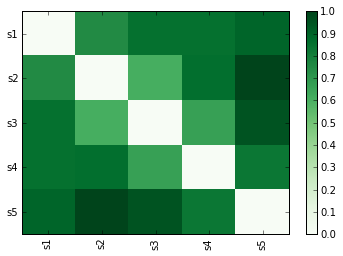

In [32]:
fig = guide_dm.plot(cmap='Greens')

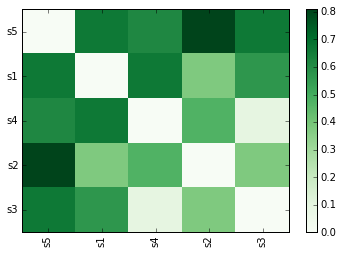

In [33]:
msa_dm = msa.distances()
fig = msa_dm.plot(cmap='Greens')

The UPGMA trees that result from these alignments are very different. First we'll look at the guide tree, and then the tree resulting from the progressive multiple sequence alignment.

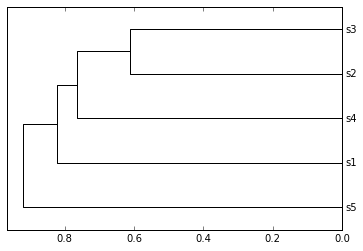

In [34]:
d = dendrogram(guide_lm, labels=guide_dm.ids, orientation='right', 
               link_color_func=lambda x: 'black')

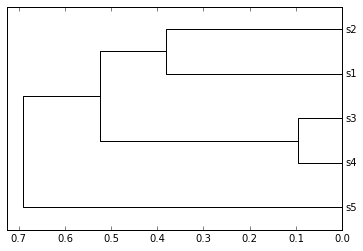

In [35]:
msa_lm = average(msa_dm.condensed_form())
d = dendrogram(msa_lm, labels=msa_dm.ids, orientation='right', 
               link_color_func=lambda x: 'black')

And we can wrap this all up in a single convenience function:

In [36]:
from iab.algorithms import progressive_msa_and_tree
%psource progressive_msa_and_tree

def progressive_msa_and_tree(sequences,
                             pairwise_aligner,
                             sequence_distance_fn=kmer_distance,
                             guide_tree=None,
                             display_aln=False,
                             display_tree=False):
    """ Perform progressive msa of sequences and build a UPGMA tree
    Parameters
    ----------
    sequences : skbio.SequenceCollection
        The sequences to be aligned.
    pairwise_aligner : function
        Function that should be used to perform the pairwise alignments,
        for example skbio.Alignment.global_pairwise_align_nucleotide. Must
        support skbio.BiologicalSequence objects or skbio.Alignment objects
        as input.
    sequence_distance_fn : function
        Function that returns and skbio.DistanceMatrix given an
        skbio.SequenceCollection. This will be used to build a guide tree if
        one is not provided.
    guide_tree : skbio.TreeNode, optional
      

>s5
---GGC--CCA-----CTGAT
>s1
ACCGGTGACCAGTTGACCAGT
>s4
---GGCACCAAACAGA--A--
>s2
ATCGGTACC-GGTAGA--AGT
>s3
---GGTACCAAATAGA--A--


Output tree:


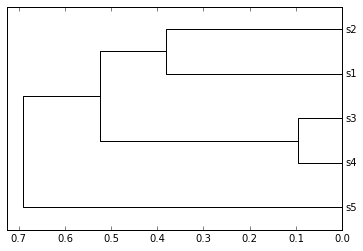

In [37]:
msa, tree = progressive_msa_and_tree(query_sequences, pairwise_aligner=global_pairwise_align_nucleotide, display_tree=True, display_aln=True)

# Progressive alignment versus iterative alignment

In an iterative alignment, the output tree from the above progressive alignment is used as a guide tree, and the full process repeated. This is performed to reduce errors that result from a low-quality guide tree. 

In [38]:
from iab.algorithms import iterative_msa_and_tree
%psource iterative_msa_and_tree

def iterative_msa_and_tree(sequences,
                           num_iterations,
                           pairwise_aligner,
                           sequence_distance_fn=kmer_distance,
                           display_aln=False,
                           display_tree=False):
    """ Perform progressive msa of sequences and build a UPGMA tree
    Parameters
    ----------
    sequences : skbio.SequenceCollection
       The sequences to be aligned.
    num_iterations : int
       The number of iterations of progressive multiple sequence alignment to
       perform. Must be greater than zero and less than five.
    pairwise_aligner : function
       Function that should be used to perform the pairwise alignments,
       for example skbio.Alignment.global_pairwise_align_nucleotide. Must
       support skbio.BiologicalSequence objects or skbio.Alignment objects
       as input.
    sequence_distance_fn : function
       Function that returns and skbio.DistanceMatrix given an
       s

>s5
---GGC--CCA-----CTGAT
>s1
ACCGGTGACCAGTTGACCAGT
>s4
---GGCACCAAACAGA--A--
>s2
ATCGGTACC-GGTAGA--AGT
>s3
---GGTACCAAATAGA--A--


Output tree:


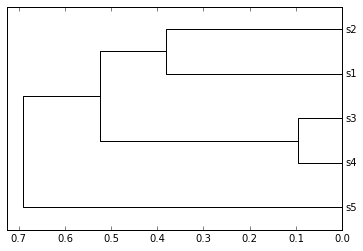

In [39]:
msa, tree = iterative_msa_and_tree(query_sequences, pairwise_aligner=global_pairwise_align_nucleotide, num_iterations=1, display_aln=True, display_tree=True)

>s5
---GGC--CCA-----CTGAT
>s4
---GGCACCAAACAGA----A
>s3
---GGTACCAAATAGA----A
>s1
ACCGGTGACCAGTTGACCAGT
>s2
ATCGGT-ACCGGTAGA--AGT


Output tree:


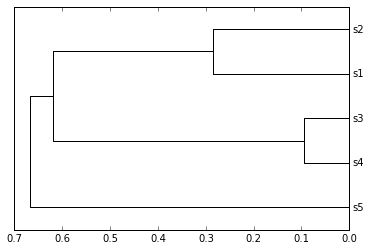

In [40]:
msa, tree = iterative_msa_and_tree(query_sequences, pairwise_aligner=global_pairwise_align_nucleotide, num_iterations=2, display_aln=True, display_tree=True)

>s5
---GGC--CCA-----CTGAT
>s4
---GGCACCAAACAGA----A
>s3
---GGTACCAAATAGA----A
>s1
ACCGGTGACCAGTTGACCAGT
>s2
ATCGGT-ACCGGTAGA--AGT


Output tree:


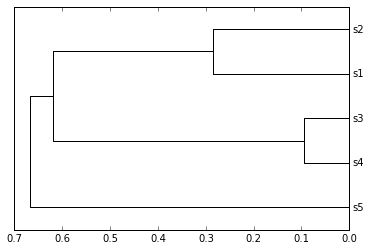

In [41]:
msa, tree = iterative_msa_and_tree(query_sequences, pairwise_aligner=global_pairwise_align_nucleotide, num_iterations=3, display_aln=True, display_tree=True)

>s5
---GGC--CCA-----CTGAT
>s4
---GGCACCAAACAGA----A
>s3
---GGTACCAAATAGA----A
>s1
ACCGGTGACCAGTTGACCAGT
>s2
ATCGGT-ACCGGTAGA--AGT


Output tree:


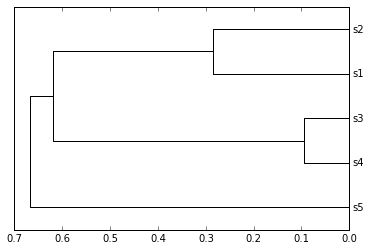

In [42]:
msa, tree = iterative_msa_and_tree(query_sequences, pairwise_aligner=global_pairwise_align_nucleotide, num_iterations=5, display_aln=True, display_tree=True)


Some references that I used in assembling these notes include [1](http://statweb.stanford.edu/~nzhang/345_web/sequence_slides3.pdf), [2](http://math.mit.edu/classes/18.417/Slides/alignment.pdf), [3](http://www.sciencedirect.com/science/article/pii/0378111988903307), [4](http://bioinformatics.oxfordjournals.org/content/23/21/2947.full), and [5](http://nar.oxfordjournals.org/content/32/5/1792.full). 